In [ ]:
# hide
# all_tutorial

# Tutorial - Conditional LSTM Language Models

>Training and using conditional LSTM language models

## LSTM Language Models

LSTM language models are a type of autoregressive generative model. This particular type of model is a good fit for RL-based optimization as they are light, robust and easy to optimize. These models make use of the [LSTM](https://arxiv.org/abs/1402.1128) architecture design.

Language models are trained in a self-supervised fashion by next token prediction. Given a series of tokens, the model predicts a probability distribution over he next token. Self supervised training is very fast and doesn't require any data labels. Each text string in the dataset labels itself.

During generation, we sample from the model in an autoregression fashion. Given an input token, the model predicts aa distribution of tokens over the next token. We then sample from that distributiona and feed the selected token back into the model. We repeat this process until either an end of sentence (EOS) token is predicted, or the generated sequence reaches a maximum allowed length.

During sampling, we save the log probability of each token predicted. This gives us a probability value for the model's estimated likelihood of the generated compound. We can also backprop through this value.

### Conditional Language Models

Conditional language models condition the generated sequences on some latent vector. Conditioning can be implemented in two ways:
- hidden conditioning: use the latent vector to initialize the hidden state of the model
- output conditioning: concatenate the latent vector to the model activations right before the LSTM layers

The latent vector itself is generated by some encoder


In [ ]:
import sys
sys.path.append('..')

from mrl.imports import *
from mrl.core import *
from mrl.chem import *
from mrl.torch_imports import *
from mrl.torch_core import *
from mrl.layers import *
from mrl.dataloaders import *
from mrl.g_models.all import *
from mrl.train.agent import *
from mrl.vocab import *

/home/dmai/miniconda3/envs/mrl/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::shared_ptr<RDKit::FilterCatalogEntry const> already registered; second conversion method ignored.
  return f(*args, **kwds)


## Setup

Before creating a model, we need to set up our data.

Our raw data is in the form of SMILES strings. We need to convert these to tensors.

First we need a `Vocab` to handle converting strings to tokens and mapping those tokens to integers. We will use the `CharacterVocab` class with the `SMILES_CHAR_VOCAB` vocabulary. This will tokenize SMILES on a character basis.

More sophisticated tokenization schemes exist, but character tokenization is nice for the simplicity. Character tokenization has a small, compact vocabulary. Other tokenization strategies can tokenize by more meaningful subwords, but these strategies create a long tail of low frequency tokens and lots of `unk` characters.

In [ ]:
df = pd.read_csv('files/smiles.csv')

In [ ]:
df.head()

,smiles
0,CNc1nc(SCC(=O)Nc2cc(Cl)ccc2OC)nc2ccccc12
1,COc1ccc(C(=O)Oc2ccc(/C=C3\C(=N)N4OC(C)=CC4=NC3...
2,Cc1sc(NC(=O)c2ccccc2)c(C(N)=O)c1C
3,COc1ccc(NCc2noc(-c3ccoc3)n2)cc1OC(F)F
4,O=C(COC(=O)c1cccc(Br)c1)c1ccc2c(c1)OCCCO2


In [ ]:
vocab = CharacterVocab(SMILES_CHAR_VOCAB)

`vocab` first tokenizes smiles into characters, then numericalizes the tokens into integer keys

In [ ]:
' '.join(vocab.tokenize(df.smiles.values[0]))

'bos C N c 1 n c ( S C C ( = O ) N c 2 c c ( C l ) c c c 2 O C ) n c 2 c c c c c 1 2 eos'

In [ ]:
' '.join([str(i) for i in vocab.numericalize(vocab.tokenize(df.smiles.values[0]))])

'0 23 27 34 11 37 34 5 30 23 23 5 20 28 6 27 34 12 34 34 5 23 36 6 34 34 34 12 28 23 6 37 34 12 34 34 34 34 34 11 12 1'

## Dataset

Now we need a dataset. For a conditional language model, we have to decide what data we want to send to the encoder to generate a latent vector. 

For this tutorial, we are going to use molecular fingerprints to generate the latent vector. The model will use the encoder to map the input fingerprint to a latent vector. Then the latent vector will be used to condition the hidden state of the decoder, which will reconstruct the SMILES string corresponding to the fingerprint.

To do this, we will use the `Vec_To_Text_Dataset` dataset with `ECFP6` as our fingerprint function 

In [ ]:
dataset = Vec_To_Text_Dataset(df.smiles.values, vocab, ECFP6)
dataloader = dataset.dataloader(32)

Now we can look at the actual data

In [ ]:
x,y = next(iter(dataloader))

In [ ]:
x

(tensor([[ 0, 23, 27,  ...,  2,  2,  2],
         [ 0, 23, 28,  ...,  2,  2,  2],
         [ 0, 23, 34,  ...,  2,  2,  2],
         ...,
         [ 0, 23,  4,  ...,  2,  2,  2],
         [ 0, 23, 23,  ...,  2,  2,  2],
         [ 0, 23, 28,  ...,  2,  2,  2]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 1., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [ ]:
y

tensor([[23, 27, 34,  ...,  2,  2,  2],
        [23, 28, 34,  ...,  2,  2,  2],
        [23, 34, 11,  ...,  2,  2,  2],
        ...,
        [23,  4, 23,  ...,  2,  2,  2],
        [23, 23, 11,  ...,  2,  2,  2],
        [23, 28, 34,  ...,  2,  2,  2]])

The `x` tensor is a tuple containing `(fingerprint, smiles_ints)`. The fingerprint (`x[1]`) will be used to generate the latent vector, while the integer-coded SMILES string (`x[0]`) will be sent to the decoder along with the latent vector.

You will notice the `y` tensor is the same as the `x[0]` tensor with the values shifted by one. This is because the goal of autoregressive language modeling is to predict the next character given the previous series of characters.

## Model Creation

We can create a model through the `Conditional_LSTM_LM` class.

First we need an encoder. Since our encoder data is a fingerprint, we will use a MLP-type encoder and set our latent vector to have a dimension of `512`

In [ ]:
enc_drops = [0.1, 0.1]
d_latent = 512

encoder = MLP_Encoder(2048, [1024, 512], d_latent, enc_drops)

Now we create the model

In [ ]:
d_vocab = len(vocab.itos)
bos_idx = vocab.stoi['bos']
d_embedding = 256
d_hidden = 1024
n_layers = 3
tie_weights = True    
input_dropout = 0.3
lstm_dropout = 0.3
 
model = Conditional_LSTM_LM(
                            encoder,
                            d_vocab,
                            d_embedding,
                            d_hidden,
                            d_latent,
                            n_layers,
                            input_dropout=input_dropout,
                            lstm_dropout=lstm_dropout,
                            norm_latent=True,
                            condition_hidden=True,
                            condition_output=False,
                            bos_idx=bos_idx,
                        )

We can examine the encoder-decoder structure of the model. We have a `MLP_Encoder` section which contains three MP layers. then we have a `decoder` section that consists of an embedding, three LSTM layers and an output layer

In [ ]:
model

Conditional_LSTM_LM(
  (encoder): MLP_Encoder(
    (layers): Sequential(
      (0): LinearBlock(
        (layers): Sequential(
          (0): Linear(in_features=2048, out_features=1024, bias=True)
          (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (1): LinearBlock(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=512, bias=True)
          (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU()
          (3): Dropout(p=0.1, inplace=False)
        )
      )
      (2): Linear(in_features=512, out_features=512, bias=True)
    )
  )
  (decoder): Conditional_LSTM_Block(
    (embedding): Embedding(47, 256)
    (lstm): Conditional_LSTM(
      (input_drop): SequenceDropout()
      (lstm_drop): SequenceDropout()
      (lstms): ModuleList(
        (0): LSTM(256, 1024, batch_fir

Now we'll put the model into a `GenerativeAgent` to manage supervised training.

We need to specify a loss function - we will use standard cross entropy

In [ ]:
loss_function = CrossEntropy()

In [ ]:
agent = GenerativeAgent(model, vocab, loss_function, dataset, base_model=False)

Now we can train in a supervised fashion on next token prediction

In [ ]:
agent.train_supervised(32, 1, 1e-3)

Epoch,Train Loss,Valid Loss,Time
0,1.94749,2.41748,00:05


This was just a quick example to show the training API. We're not going to do a whole training process here. To train custom models, repeat this code with your own set of SMILES.

## Pre-trained Models

The MRL model zoo offers a number of pre-trained models. We'll load one of these to continue.

We'll use the `LSTM_LM_Small_Chembl` model. This model was trained first on a chunk of the ZINC database

In [ ]:
del model
del agent
gc.collect()
torch.cuda.empty_cache()

In [ ]:
from mrl.model_zoo import FP_Cond_LSTM_LM_Small_ZINC

In [ ]:
agent = FP_Cond_LSTM_LM_Small_ZINC(drop_scale=0.5, base_model=False)

Now with a fully pre-trained model, we can look at drawing samples

In [ ]:
preds, lps = agent.model.sample_no_grad(256, 100, temperature=1.)

In [ ]:
preds

tensor([[23, 23,  5,  ...,  2,  2,  2],
        [23, 23, 27,  ...,  2,  2,  2],
        [23, 28, 23,  ...,  2,  2,  2],
        ...,
        [23, 23, 28,  ...,  2,  2,  2],
        [23, 34, 11,  ...,  2,  2,  2],
        [23, 28, 23,  ...,  2,  2,  2]], device='cuda:0')

In [ ]:
lps.shape

torch.Size([256, 100])

The `sample_no_grad` function gives is two outputs - `preds` and `lps`.

`preds` is a long tensor of size `(bs, sl)` containing the integer tokens of the samples.

`lps` is a float tensor of size `(bs, sl)` containing the log probabilities of each value in `preds`

We can now reconstruct the predictions back into SMILES strings

In [ ]:
smiles = agent.reconstruct(preds)

In [ ]:
smiles[:10]

['COC(=O)[C@@H](C)Cc1ccc(Cl)cc1NC(=O)NCC(C)(C)c1cccc(OC)c1',
 'Cc1cc(C(=O)N[C@@H]2CC(=O)N([C@H](C)c3ccccc3)C2)c(C)cc1OCC(=O)NC',
 'CCOc1cccc(=O)n1CC(=O)NCc1ccc(F)cc1C(F)F',
 'C[C@H](N(CC(F)F)C(=O)N(C)CC1CC1)c1ccc(OC(C)(C)C)cc1',
 'CC(C)C[C@H]1CN(C(=O)C(=O)Nc2cc(C(C)C)ccc2OCCC)C[C@H]1C',
 'Cc1ccccc1NC(=O)c1cc(F)cnc1SCc1cc2c(c(C)c1)O[C@@H](C)C2',
 'C[C@H]1C[C@H](N)CN(C(=O)CSCc2ccc3c(c2)CCC(F)(F)C3)C1',
 'CC(=O)Oc1cccc(F)c1NC(=O)[C@H](C)N(Cc1ccc(F)cc1)Cc1ccc(C)s1',
 'CNC(=O)[C@@H]1CCCN(C(=O)Nc2c(-n3cccc3)ccc3ccc(N)cc32)C1',
 'CSc1cc(C(=O)NN2CC(CC(=O)NC(C)C)C2)c2cc(F)ccc2n1']

In [ ]:
mols = to_mols(smiles)

Now lets look at some key generation statistics. 

- diversity - the percentage of unique samples
- valid - the number of chemically valid samples

In [ ]:
div = len(set(smiles))/len(smiles)
val = len([i for i in mols if i is not None])/len(mols)
print(f'Diversity:\t{div:.3f}\nValid:\t\t{val:.3f}')

Diversity:	1.000
Valid:		0.980


In [ ]:
valid_mols = [i for i in mols if i is not None]

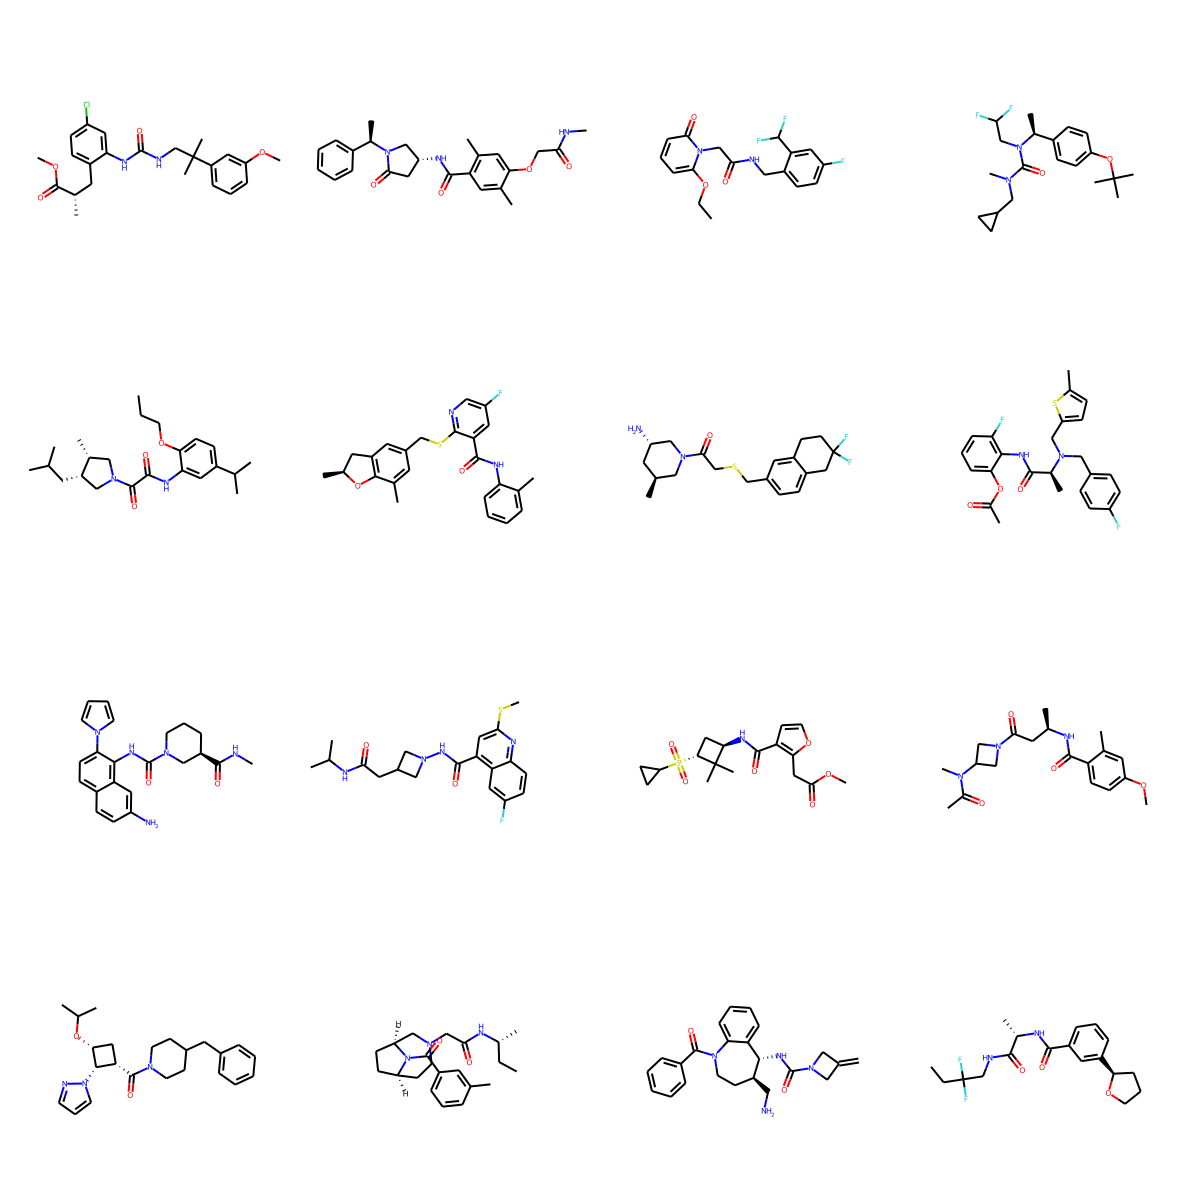

In [ ]:
draw_mols(valid_mols[:16], mols_per_row=4)

## Conditional Generation

Lets look further at how conditional generation works. One important aspect of conditioning on a latent space is the ability to sample from it. This poses an interesting challenge for a conditional language model, because unlike models like `VAE`, there is no set prior distribution. 

The `Conditional_LSTM_LM` class handles this with the `norm_latent` argument. If `norm_latent=true` (as above), the latent vectors are all normalized to a magnitude of 1 before being sent to the decoder. This is similar to what is done in StyleGan-type models.

By setting the norm constraint, we can sample valid latent vectors by sampling from a normal distribution and normalizing the resulting vectors.

In [ ]:
latents = to_device(torch.randn((64, agent.model.encoder.d_latent)))

In [ ]:
preds, lps = agent.model.sample_no_grad(latents.shape[0], 100, z=latents, temperature=1.)
smiles = agent.reconstruct(preds)
mols = to_mols(smiles)
mols = [i for i in mols if i is not None]

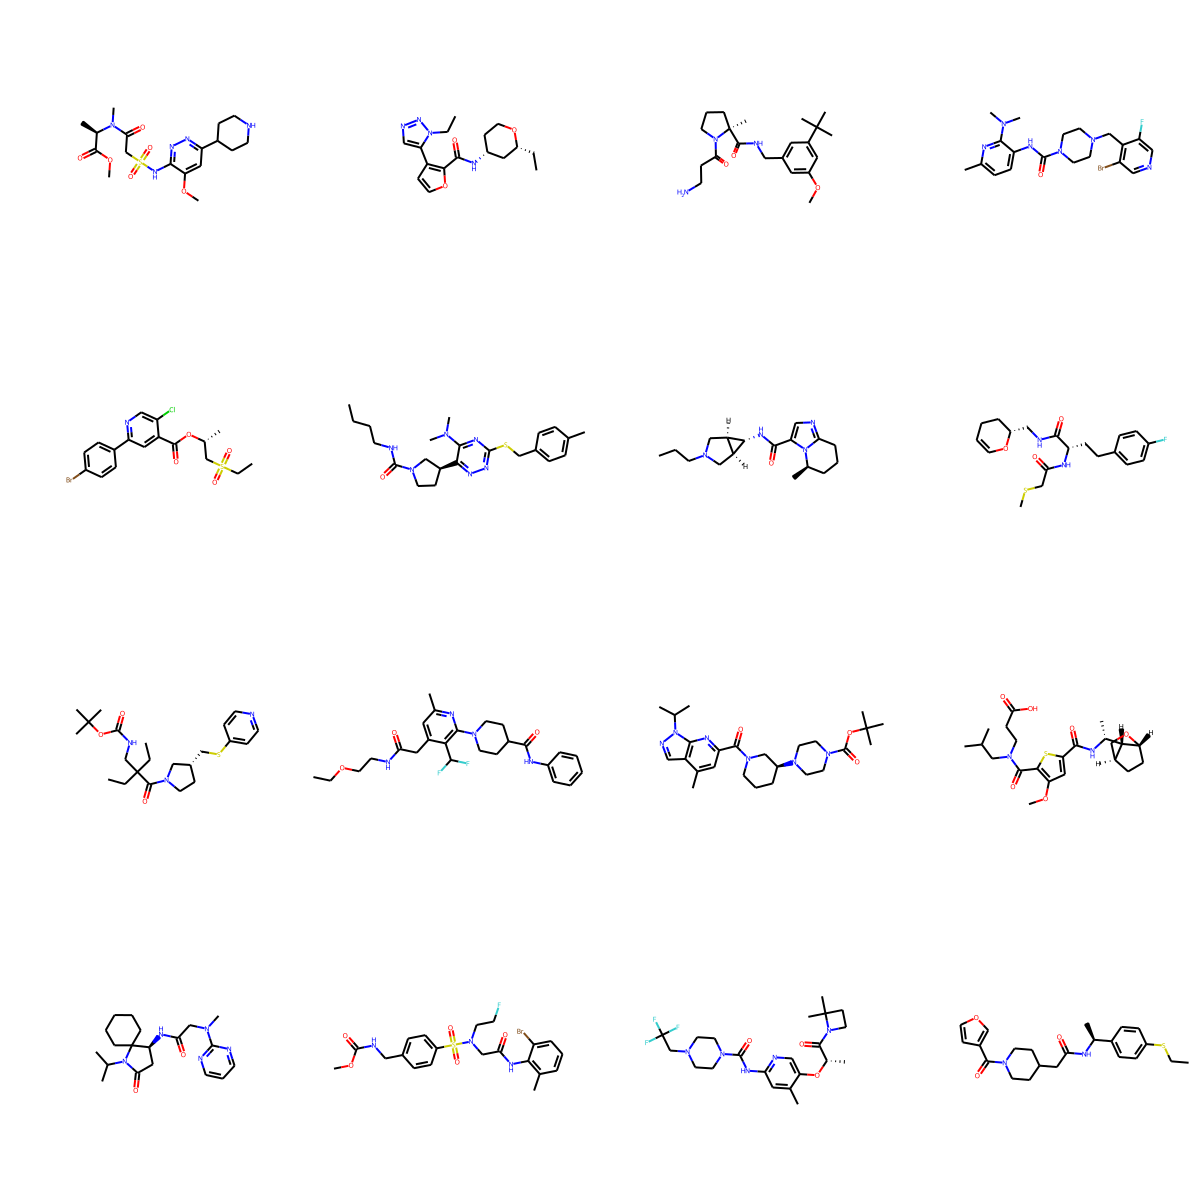

In [ ]:
draw_mols(mols[:16], mols_per_row=4)

## Conditional Samples on a Single Input

One advantage of using a conditional generation is the ability to sample multiple compounds from a specific input.

Here we get a latent vector from a specific molecule in the datase

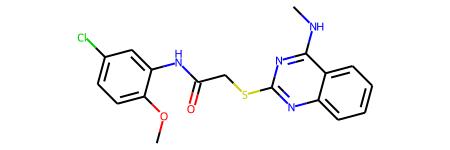

In [ ]:
smile = df.smiles.values[0]
to_mol(smile)

In [ ]:
smile_ds = dataset.new([smile])
batch = to_device(smile_ds.collate_function([smile_ds[0]]))
x,y = batch

In [ ]:
agent.model.eval();

In [ ]:
latents = agent.model.x_to_latent(x)

In [ ]:
latents.shape

torch.Size([1, 512])

Now we sample 64 molecules from the same latent vector. The diversity of the outputs will depend on the sampling temperature used and the degree of dropout (if enabled)

In [ ]:
agent.model.train();

In [ ]:
preds, lps = agent.model.sample_no_grad(64, 100, z=latents.repeat(64,1), temperature=1.)
smiles = agent.reconstruct(preds)
print(len(set(smiles)), len(set(smiles))/len(smiles))
smiles = list(set(smiles))

10 0.15625


In [ ]:
mols = to_mols(smiles)
mols = [i for i in mols if i is not None]

In [ ]:
len(mols)

10

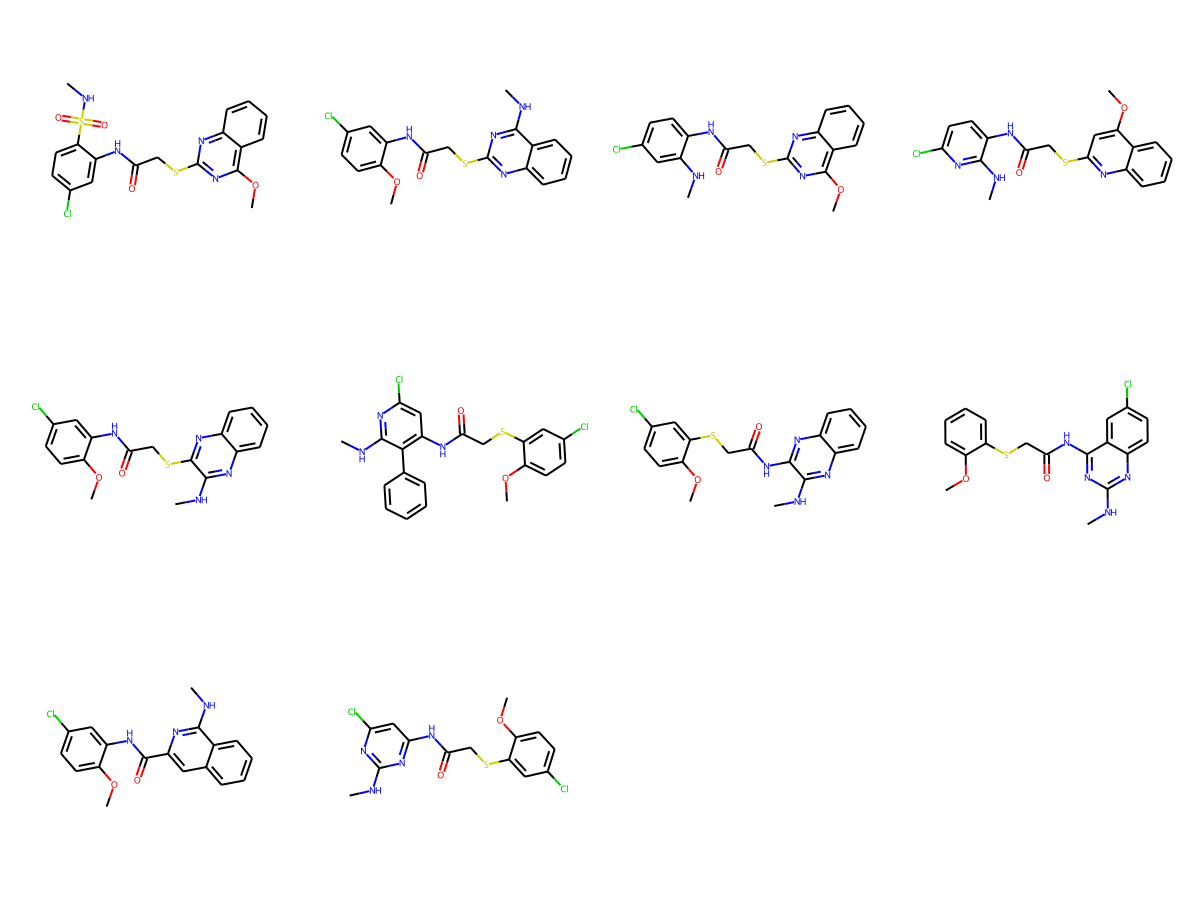

In [ ]:
draw_mols(mols[:16], mols_per_row=4)

In the above section, we generated 64 compounds and ended up with 10 unique SMILES strings.

If we want more diversity, we can sample with a higher temperature.

You'll see we get 40 unique SMILES. However, only 36 of them are valid SMILES strings. This is the tradeoff of using higher sampling temperatures

In [ ]:
preds, lps = agent.model.sample_no_grad(64, 100, z=latents.repeat(64,1), temperature=2.)
smiles = agent.reconstruct(preds)
print(len(set(smiles)), len(set(smiles))/len(smiles))
smiles = list(set(smiles))

40 0.625


In [ ]:
mols = to_mols(smiles)
mols = [i for i in mols if i is not None]

In [ ]:
len(mols)

36

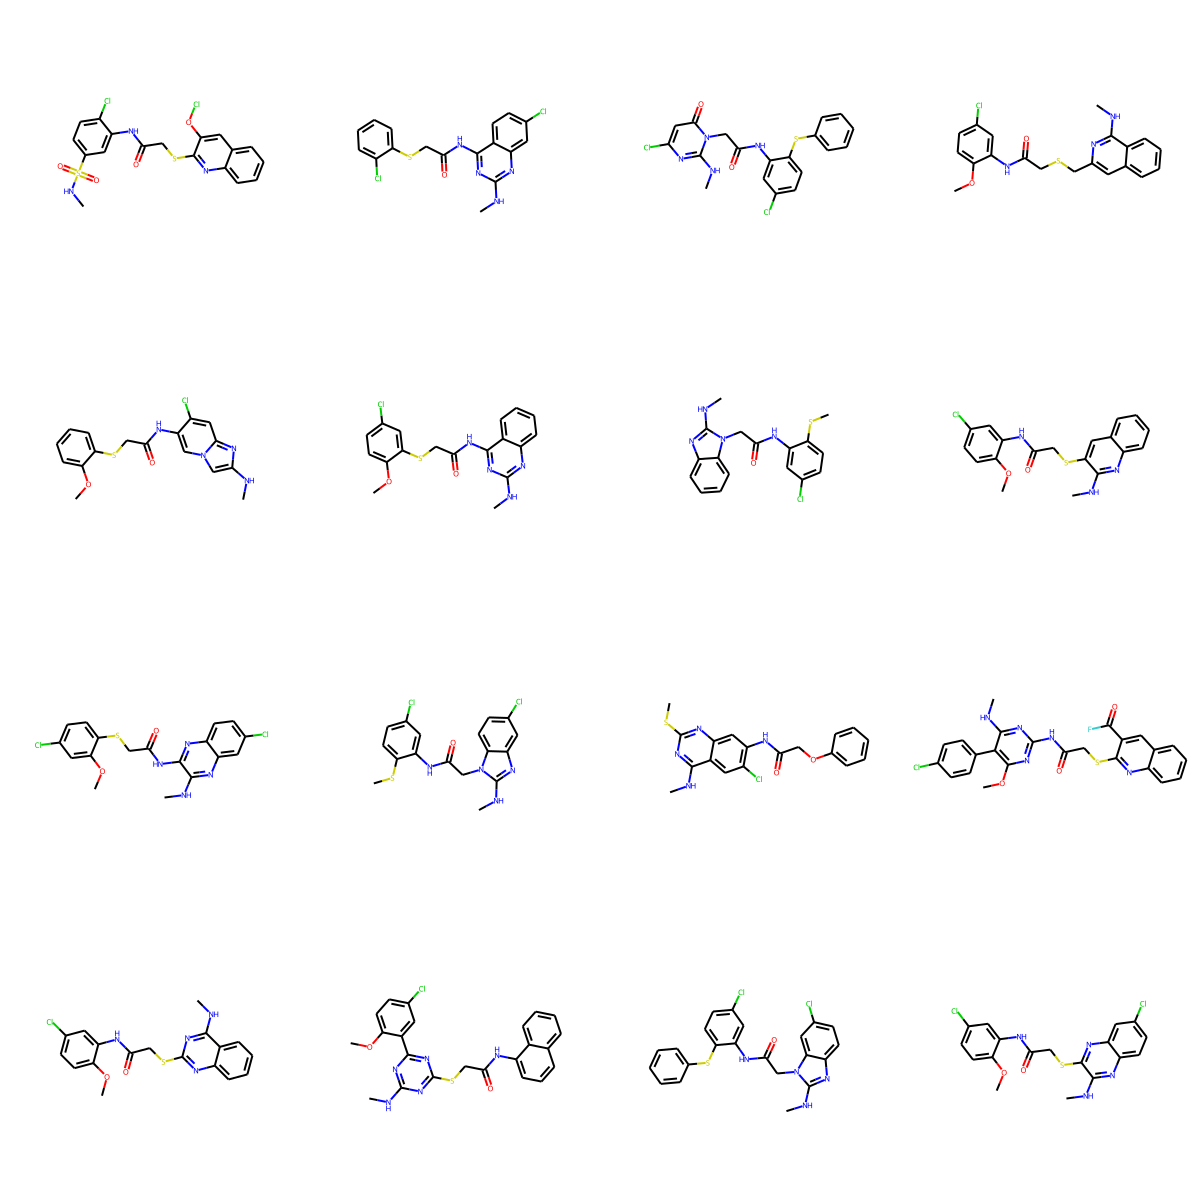

In [ ]:
draw_mols(mols[:16], mols_per_row=4)

## Prior

The `Conditional_LSTM_LM` supports a defined prior distrribution for sampling. By default, this prior is not enabled.

We can set the prior using the latent vector we generated earlier to focus the model's prior distribution on that area of the latent space.

To create this distribution, we first need to define the log-variance of the latent space. We will set the log variance to `-5` to set aa tight distribution around the latent vector.

In [ ]:
logvar = to_device(torch.zeros(latents.shape)-5)

In [ ]:
agent.model.set_prior_from_latent(latents.squeeze(0), logvar.squeeze(0), trainable=False)

In [ ]:
preds, lps = agent.model.sample_no_grad(128, 100, temperature=1.)
smiles = agent.reconstruct(preds)
print(len(set(smiles)), len(set(smiles))/len(smiles))
smiles = list(set(smiles))

26 0.203125


In [ ]:
mols = to_mols(smiles)
mols = [i for i in mols if i is not None]

In [ ]:
len(mols)

25

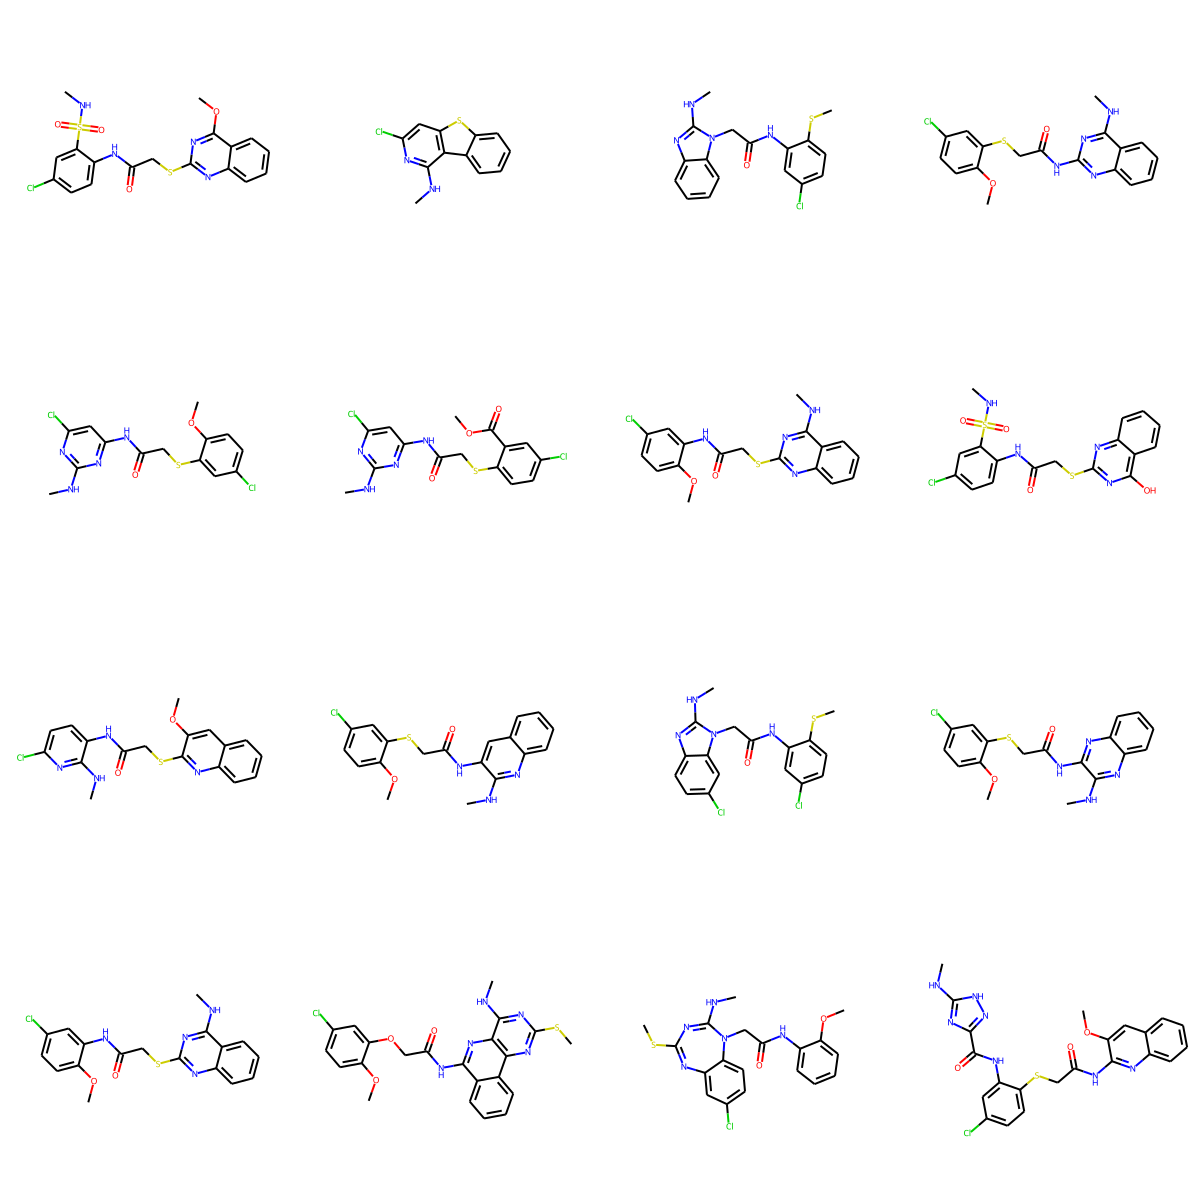

In [ ]:
draw_mols(mols[:16], mols_per_row=4)

With the small but nonzero variance around the latent vector, we get compounds that are different but share many of the features of the original molecule